In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.tsa.stattools as smt
from scipy.optimize import curve_fit

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.tsatools import detrend

from statsmodels.tsa.vector_ar.vecm import coint_johansen

from sklearn.neighbors import KernelDensity

### Replication of single-run plots

In [6]:
df_1 = pd.read_csv('validation_samples/valoutput_2.csv')

In [7]:
T = range(len(df_1.GDP))

In [8]:
def indexnumber(ts):
    return 100 * ts / ts[0]

In [9]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [10]:
# Set parameters for bandpass filters
bk_low = 18
bk_high = 96
bk_K = 36

* SF1 Endogenous and self-sustained growth of output, with persistent fluctuations.
* SF4 Aggregate consumption is less volatile than GDP, and aggregate investments are
more volatile than GDP.
* SF6 Synchronization of the business cycle and emission dynamics.

(Partial) replication of Dosi (2010) fig 1 and 2, Lamperti et al (2018) fig 2 and 8

In [7]:
real_GDP_1 = df_1.GDP.iloc[300:].to_numpy() / df_1.prices.iloc[300:].to_numpy()
real_C = df_1.C.iloc[300:].to_numpy() / df_1.prices.iloc[300:].to_numpy()
real_I = df_1.I.iloc[300:].to_numpy() / df_1.prices.iloc[300:].to_numpy()

In [8]:
x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP_1), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(real_C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(real_I), bk_low, bk_high, bk_K)

Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.Em.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_1.EnDem.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)

T_filter = range(len(gdp_filtered))

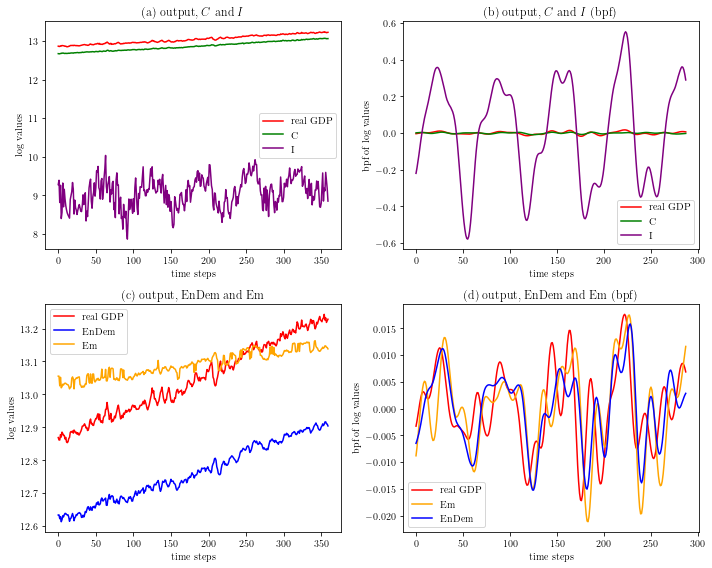

In [12]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))

ax1.plot(np.log(real_GDP_1), label='real GDP', color='red')
ax1.plot(np.log(real_C), label='C', color='green')
ax1.plot(np.log(real_I), label='I', color='purple')
ax1.set_ylabel('log values')
ax1.set_xlabel('time steps')
ax1.set_title('(a) output, $C$ and $I$')
ax1.legend()

ax2.plot(gdp_filtered, label='real GDP', color='red')
ax2.plot(C_filtered, label='C', color='green')
ax2.plot(I_filtered, label='I', color='purple')
ax2.set_xlabel('time steps')
ax2.set_ylabel('bpf of log values')
ax2.set_title('(b) output, $C$ and $I$ (bpf)')
ax2.legend()

ax3.plot(np.log(real_GDP_1), label='real GDP', color='red')
ax3.plot(np.log(df_1.EnDem.iloc[300:].to_numpy()), label='EnDem', color='blue')
ax3.plot(np.log(df_1.Em.iloc[300:].to_numpy()), label='Em', color='orange')
ax3.set_xlabel('time steps')
ax3.set_ylabel('log values')
ax3.set_title('(c) output, EnDem and Em')
ax3.legend()

ax4.plot(gdp_filtered, label='real GDP', color='red')
ax4.plot(Em_filtered, label='Em', color='orange')
ax4.plot(EnDem_filtered, label='EnDem', color='blue')
ax4.set_xlabel('time steps')
ax4.set_ylabel('bpf of log values')
ax4.set_title('(d) output, EnDem and Em (bpf)')
ax4.legend()

plt.tight_layout()
plt.savefig('../validation/timeseries_gdp.pdf', bbox_inches='tight')
plt.show()

(Partial) replication of Lamperti et al (2018) fig 7

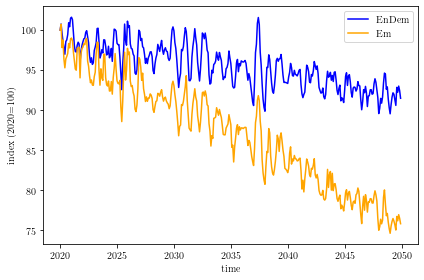

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(indexnumber(df_1.EnDem.iloc[300:].to_numpy() / real_GDP_1), c='blue', label='EnDem')
ax.set_xlabel('time')
ax.set_ylabel('index (2020=100)')
ax.set_xticks(x, years)

ax.plot(indexnumber(df_1.Em.iloc[300:].to_numpy() / real_GDP_1), c='orange', label='Em')
ax.set_xlabel('time')
ax.set_xticks(x, years)

ax.legend()

plt.tight_layout()
plt.savefig('../validation/Em_EnDem.pdf', bbox_inches='tight')
plt.show()

## Firm characteristics

In [11]:
df_firms = pd.read_csv('validation_samples/valfirmdata_2.csv')
df_firms.head()

,t,agecp_2501,agecp_2502,agecp_2503,agecp_2504,agecp_2505,agecp_2506,agecp_2507,agecp_2508,agecp_2509,...,Kcp_2691,Kcp_2692,Kcp_2693,Kcp_2694,Kcp_2695,Kcp_2696,Kcp_2697,Kcp_2698,Kcp_2699,Kcp_2700
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2400.0,2400.000000,2340.000000,2340.000000,2400.0,2400.000000,2400.0,2340.000000,2400.000000,2400.000000
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2400.0,2339.749023,2340.000000,2340.000000,2400.0,2400.000000,2340.0,2358.437205,2400.000000,2340.000000
2,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,2400.0,2339.749023,2340.000000,2353.971973,2340.0,2400.000000,2340.0,2358.437205,2340.000000,2353.971973
3,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,2340.0,2339.749023,2280.000000,2293.971973,2280.0,2417.426719,2340.0,2358.437205,2298.681748,2353.971973
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,2340.0,2339.749023,2219.347797,2233.971973,2220.0,2417.426719,2280.0,2358.437205,2238.681748,2233.971973


In [12]:
start_t = 300

In [13]:
def mean_std_firmdata(colstart):
    all_ts = [col for col in df_firms if col.startswith(colstart)]
    ts_mean = df_firms[all_ts].iloc[start_t:].mean(axis=1)
    ts_std = df_firms[all_ts].iloc[start_t:].std(axis=1)
    return ts_mean, ts_std

(Partial) replication of Dosi (2010) fig 5

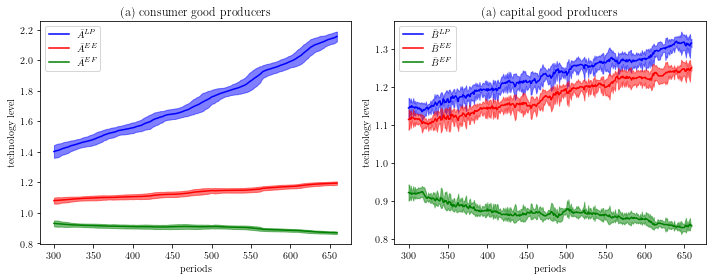

In [14]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))

for colstart, color, label in zip(['LPcp', 'EEcp', 'EFcp'], ['blue', 'red', 'green'], ['$\\bar{A}^{LP}$', '$\\bar{A}^{EE}$', '$\\bar{A}^{EF}$']):
    ts_mean, ts_std = mean_std_firmdata(colstart)
    ax1.plot(ts_mean, color=color, label=label)
    ax1.fill_between(np.arange(300,660), ts_mean + 2 * ts_std, ts_mean - 2 * ts_std, alpha=0.5, color=color)

ax1.legend(loc='upper left')
ax1.set_xlabel('periods')
ax1.set_ylabel('technology level')
ax1.set_title('(a) consumer good producers')

for colstart, color, label in zip(['LPkp', 'EEkp', 'EFkp'], ['blue', 'red', 'green'], ['$\\bar{B}^{LP}$', '$\\bar{B}^{EE}$', '$\\bar{B}^{EF}$']):
    ts_mean, ts_std = mean_std_firmdata(colstart)
    ax2.plot(ts_mean, color=color, label=label)
    ax2.fill_between(np.arange(300,660), ts_mean + 2 * ts_std, ts_mean - 2 * ts_std, alpha=0.5, color=color)

ax2.legend(loc='upper left')
ax2.set_xlabel('periods')
ax2.set_ylabel('technology level')
ax2.set_title('(a) capital good producers')

plt.tight_layout()
plt.savefig('../../plotting/validation/tech_het.pdf', bbox_inches='tight')
plt.show()

(Partial) replication of Dosi (2010) fig 6

In [15]:
I_cols = [col for col in df_firms if col.startswith("Icp")]
K_cols = [col for col in df_firms if col.startswith("Kcp")]
I_ratio = df_firms[I_cols].to_numpy() / df_firms[K_cols].to_numpy()

In [16]:
# Make investment ratio's quarterly
I_month = df_firms[I_cols].to_numpy()
K_month = df_firms[K_cols].to_numpy()

I_ratio_quarterly = np.array([np.sum(I_month[i:i+3, :] / K_month[i:i+3, :], axis=0) for i in np.arange(0, 660, step=3)])

In [17]:
counts = np.zeros((50, 120))

for col in range(120):
    for i, row in enumerate(np.arange(0.0, 0.5, step=0.01)):
        counts[i, col] = ((I_ratio_quarterly >= row) & (I_ratio_quarterly < row + 0.1)).sum() / I_ratio_quarterly[:, col].sum()

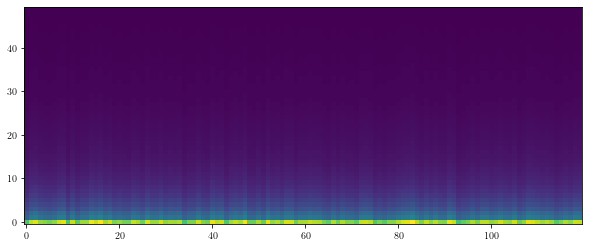

In [18]:
plt.figure(figsize=(10, 4))
plt.imshow(counts, aspect='auto', origin='lower')
plt.show()

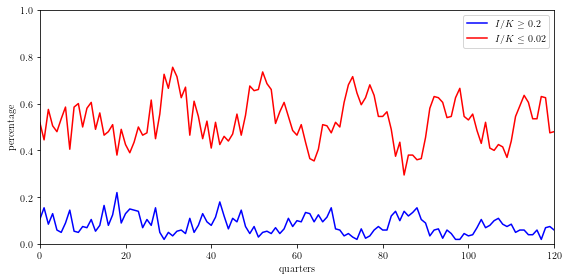

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(np.sum(I_ratio_quarterly >= 0.2, axis=1) / 200, label='$I/K \geq 0.2$', color='blue')
plt.plot(np.sum(I_ratio_quarterly <= 0.02, axis=1) / 200, label='$I/K \leq 0.02$', color='red')

plt.xlim(99, 219)
plt.ylim(0, 1)
plt.xticks(np.arange(99, 220, step=20), np.arange(0, 121, step=20))
plt.xlabel('quarters')
plt.ylabel('percentage')
plt.legend()

plt.tight_layout()
plt.savefig('../../plotting/validation/lumpiness.pdf', bbox_inches='tight')
plt.show()

In [22]:
S_cp_cols = [col for col in df_firms if col.startswith('Scp')]
S_cp_month = df_firms[S_cp_cols].to_numpy()[300:,:]

print(S_cp_month.shape)

# Pool data to be yearly
S_cp_year = np.array([np.sum(S_cp_month[i:i+3, :], axis=0) for i in np.arange(0, 360, step=3)])

print(S_cp_year.shape)


S_cp_year_mean = np.mean(S_cp_year, axis=1)

print(S_cp_year_mean)

S_cp_year_norm = np.transpose(np.transpose(S_cp_year) / S_cp_year_mean)
S_cp_year_norm = np.sort(S_cp_year_norm.flatten())[::-1]


(360, 200)
(120, 200)
[6215.22998616 6238.22551733 6214.21041702 6187.02593689 6116.5223353
 6088.05194914 6156.48490823 6140.14946779 6121.09436884 6079.63902103
 6064.59308913 6079.0815994  6107.28071859 6065.14981676 6148.24451983
 6110.83052172 6116.88363364 6155.00064476 6155.05428671 6084.89960757
 6080.11949477 6185.13474274 6132.11808172 6116.60659795 6066.75124803
 6008.14098701 6092.90726383 6031.93365372 5994.12429183 5964.93941709
 5921.05149828 5894.18402335 5906.05371879 5924.02517018 5943.81108638
 5916.54821122 5904.37667419 5918.07058886 5939.10755983 5880.99243536
 5827.29551232 5899.06391884 5935.21606162 5874.8981392  5842.1879488
 5868.25059034 5902.48512516 5820.85295905 5821.97482667 5841.65472267
 5787.30296943 5705.73234502 5717.03809937 5694.02821248 5678.20885468
 5649.97887567 5634.63618204 5679.26237674 5687.36273818 5638.63097236
 5636.46350892 5693.2222182  5726.95524262 5720.31510514 5726.31865061
 5665.4926064  5677.90886155 5703.80216659 5752.5552516  

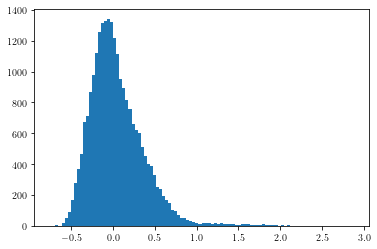

In [34]:
firm_gr = (S_cp_year[:, 1:] - S_cp_year[:, :-1]) / S_cp_year[:, :-1]

plt.hist(firm_gr.flatten(), bins=100)
plt.show()

In [23]:
print(S_cp_year_norm.shape)

(24000,)


In [24]:
s, loc, scale = stats.lognorm.fit(S_cp_year_norm)

S_fitted = stats.lognorm.rvs(s, loc, scale, size=len(S_cp_year_norm))
rv = stats.lognorm(s, loc, scale)
# S_fitted = np.sort(S_fitted)[::-1]

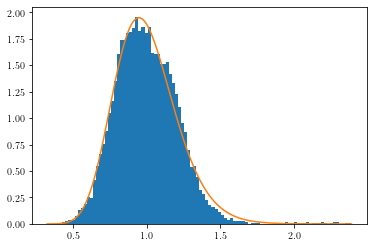

0.3235599376053806
2.390530838330277


In [25]:
x = np.linspace(min(S_cp_year_norm), max(S_cp_year_norm), 1000)
plt.hist(S_cp_year_norm, bins=100, density=True)
plt.plot(x, rv.pdf(x))
plt.show()

print(min(S_cp_year_norm))
print(max(S_cp_year_norm))

In [26]:
firmsizetable = {}

jb_val, p_val = stats.jarque_bera(np.log(S_cp_year_norm))
print(jb_val, p_val)

firmsizetable['Jarque-Bera'] = [jb_val, round(p_val, 2)]

stat, p_val = stats.shapiro(np.log(S_cp_year_norm))
print(stat, p_val)

firmsizetable['Shapiro-Wilkes'] = [stat, round(p_val, 2)]

stat, crit, p_val = stats.anderson(np.log(S_cp_year_norm), dist='norm')
print(stat, crit, p_val)

firmsizetable['Anderson-Darling'] = [stat, 0.0]

df_firmtable = pd.DataFrame(firmsizetable, index=['test stat', 'p-val']).round(2)
print(df_firmtable.head())

print(df_firmtable.to_latex())

466.82530037171216 0.0
0.9926652312278748 1.1090019985892463e-32
26.038208346210013 [0.576 0.656 0.787 0.918 1.092] [15.  10.   5.   2.5  1. ]
           Jarque-Bera  Shapiro-Wilkes  Anderson-Darling
test stat       466.83            0.99             26.04
p-val             0.00            0.00              0.00
\begin{tabular}{lrrr}
\toprule
{} &  Jarque-Bera &  Shapiro-Wilkes &  Anderson-Darling \\
\midrule
test stat &       466.83 &            0.99 &             26.04 \\
p-val     &         0.00 &            0.00 &              0.00 \\
\bottomrule
\end{tabular}



/home/joosakkerman/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


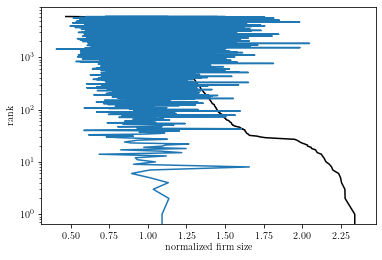

In [70]:
x = np.linspace(min(S_cp_year_norm), max(S_cp_year_norm), 1000)
plt.plot(S_cp_year_norm, range(len(S_cp_year_norm)), c='black')
plt.plot(S_fitted, range(len(S_fitted)))
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('normalized firm size')
plt.ylabel('rank')
plt.show()

## Income and wealth distributions

In [156]:
def powerlaw(x, alpha, beta):
    return beta * x ** (-1 - alpha)

In [224]:
df_I_W = pd.read_csv('../result_data/final_income_dists.csv')

start_60 = round(20/100 * 2500)
end_60 = round(80/100 * 2500)

I_sorted = np.sort(df_I_W.all_I.to_numpy())
I_share = sum(I_sorted[start_60:end_60]) / sum(I_sorted)
print("I share:", I_share)

W_sorted = np.sort(df_I_W.all_W.to_numpy())
W_share = sum(W_sorted[start_60:end_60]) / sum(W_sorted)
print("W share:", W_share)

I share: 0.5708016867882133
W share: 0.5353320446709835


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


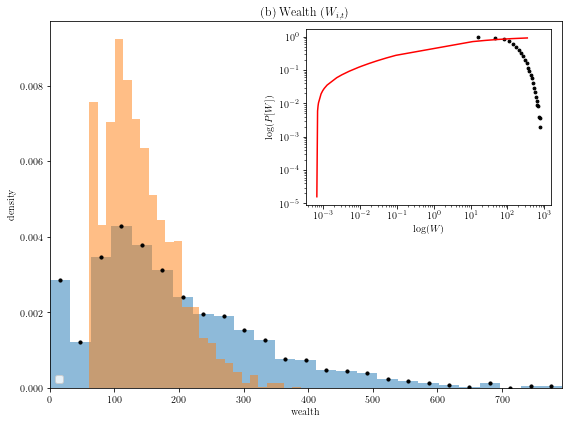

In [238]:
fig, ax = plt.subplots(figsize=(8,6))

dens, bins, _ = ax.hist(df_I_W.all_W, bins=25, density=True, alpha=0.5)
ax.hist(df_I_W.all_I, bins=25, density=True, alpha=0.5)
bins1 = bins[:-1]
bins2 = bins[1:]
bins = np.mean([bins1, bins2], axis=0)

idx = np.where(dens != 0)[0][10:]
[alpha_hat, beta_hat], [alpha_cov, beta_cov] = curve_fit(powerlaw, bins[idx], dens[idx])
start_W = 2200

ax.scatter(bins, dens, s=10, color='black')
ax.set_title('(b) Wealth ($W_{i,t}$)')
ax.set_xlim(0, max(df_I_W.all_W))
# ax.set_ylim(min(dens), max(dens))

ax.set_ylabel('density')
ax.set_xlabel('wealth')
ax.legend(loc='lower left')

# start_W = 2350

start_main = 100

dens_cumm = np.cumsum(dens[::-1])[::-1] / np.sum(dens)

s, loc, scale = stats.lognorm.fit(W_sorted[start_main:start_W])

axins = ax.inset_axes([0.5, 0.5, 0.48, 0.48])
# axins.plot(W_sorted[start_W:], powerlaw(W_sorted[start_W:], alpha_hat, beta_hat), color='red')
axins.plot(W_sorted[start_main:start_W][::-1], stats.lognorm.cdf(W_sorted[start_main:start_W][::-1], s, loc, scale), color='red')
# axins.plot(W_sorted[2250:], stats.powerlaw.pdf(W_sorted[2250:], a, loc, scale))
axins.set_yscale('log')
axins.set_xscale('log')
axins.set_ylabel('$\\log (P[W])$')
axins.set_xlabel('$\\log (W)$')
axins.scatter(bins, dens_cumm, s=8, color='black')

plt.tight_layout()
plt.show()

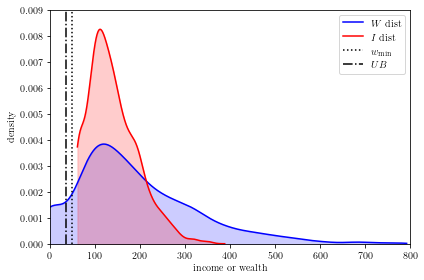

In [292]:
fig, ax = plt.subplots(figsize=(6, 4))

kde = stats.gaussian_kde(df_I_W.all_W.to_numpy())

W_range = np.linspace(min(df_I_W.all_W), max(df_I_W.all_W), 1000)
prob = kde(W_range)

ax.plot(W_range, prob, label='$W$ dist', color='blue')
ax.fill_between(W_range, prob, alpha=0.2, color='blue')

kde = stats.gaussian_kde(df_I_W.all_I.to_numpy())

I_range = np.linspace(min(df_I_W.all_I), max(df_I_W.all_I), 1000)
prob = kde(I_range)

ax.plot(I_range, prob, label='$I$ dist', color='red')
ax.fill_between(I_range, prob, alpha=0.2, color='red')

ax.set_xlim(0, 800)
ax.set_ylim(0.0, 0.009)
ax.set_xlabel('income or wealth')
ax.set_ylabel('density')

ax.axvline(50, c='black', linestyle='dotted', label='$w_{\min}$')
ax.axvline(35, c='black', linestyle='dashdot', label='$UB$')
ax.legend()

plt.tight_layout()
plt.savefig('../../plotting/validation/I_W_dist.pdf', bbox_inches='tight')
plt.show()

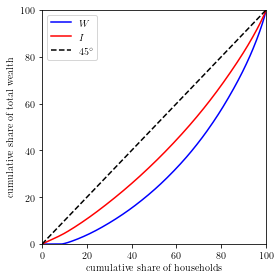

In [291]:
fig, ax = plt.subplots(figsize=(4, 4))

W_sorted = np.sort(df_I_W.all_W)
I_sorted = np.sort(df_I_W.all_I)

ax.plot(100 * np.linspace(0, 1, len(W_sorted)), 100 * np.cumsum(W_sorted) / np.sum(W_sorted), color='blue', label='$W$')
ax.plot(100 * np.linspace(0, 1, len(W_sorted)), 100 * np.cumsum(I_sorted) / np.sum(I_sorted), color='red', label='$I$')
ax.plot([0, 100], [0, 100], linestyle='dashed', c='black', label='$45^\circ$')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.legend()
ax.set_xlabel('cumulative share of households')
ax.set_ylabel('cumulative share of total wealth')

plt.tight_layout()
plt.savefig('../../plotting/validation/lorenz.pdf', bbox_inches='tight')
plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[-2.84217094e-14  4.49220602e+01  8.44464654e+01  1.09029484e+02
  1.33369235e+02  1.59634024e+02  1.91878453e+02  2.34620686e+02
  2.90882013e+02  3.69197449e+02]


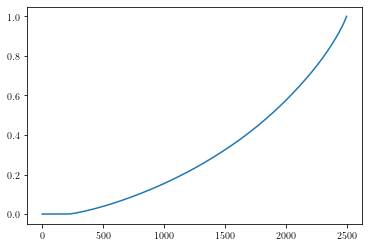

In [271]:
print(np.arange(0, 1, step=0.1))

W_sorted = np.sort(df_I_W.all_W)

plt.plot(np.cumsum(W_sorted) / np.sum(W_sorted))

W_quatiles = np.quantile(df_I_W.all_W.to_numpy(), np.arange(0, 1, step=0.1))

print(W_quatiles)

# W_counts = np.count()

## Aggregate results

In [30]:
# Open all validation files

def filepath(i):
    return f'validation_samples/valoutput_{i}.csv'

# n_MC = 100
n_MC = 10

df_list = []
for MC_i in range(1, n_MC + 1):
    df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])
df = pd.concat(df_list)

* SF7 Co-integration of output, energy demand and emissions.

(Partial) reproduction of table 3

In [300]:
df.head()

,C,Em,EmIndex,EnDem,EnPerc,GDP,GDP_growth,GINI_I,GINI_W,I,...,avg_π_LP,bankrupty_cp,dU,inventories,markups,prices,total_Q_cp,total_Q_growth,total_Q_kp,wages
300,432124.732177,480336.844427,100.741317,305323.370479,0.411982,521521.089472,-1.478237,0.248433,0.473953,6853.433293,...,1.322235,0.0,-30.821918,16249.120147,0.266388,1.439462,303996.017473,0.033485,5800.0,1.250350
301,426261.263709,482170.414654,101.125873,307295.837448,0.410415,509325.890857,-6.198351,0.241344,0.470922,10468.936811,...,1.323549,0.0,-21.093750,22493.104382,0.267373,1.433009,303602.407044,0.024141,8300.0,1.250536
302,425507.120677,483439.648367,101.392070,308693.719220,0.409338,508900.513445,-2.567307,0.245649,0.469935,10909.727604,...,1.324531,0.0,-29.565217,32316.860645,0.266738,1.441467,304977.093949,0.024253,8350.0,1.249633
303,426552.495906,482043.570085,101.099270,307258.737200,0.410523,510057.985834,-1.728457,0.242795,0.468207,8779.315500,...,1.325111,0.0,-9.900990,39502.434422,0.267074,1.432584,304918.472103,0.007013,7050.0,1.244356
304,424598.808485,481634.761807,101.013530,306897.454734,0.410872,508599.896731,0.314576,0.241734,0.466052,9918.687476,...,1.326072,0.0,0.000000,45581.966591,0.266827,1.426479,303714.448609,-0.000442,8050.0,1.245277


In [301]:
gdp_detrend = sm.tsa.tsatools.detrend(df_list[0].GDP / df_list[0].prices)
EnDem_detrend = sm.tsa.tsatools.detrend(df_list[0].EnDem)

# plt.plot(np.log(df_list[1].total_Q_cp))
# plt.plot(np.log(df_list[1].EnDem))

coint_t, pval, crit = sm.tsa.stattools.coint(
    df_list[1].GDP / df_list[1].prices, 
    df_list[1].EnDem, 
    trend='ct',
    autolag=None,
    maxlag=10
)
print(coint_t, pval, crit)

-3.4117781709896486 0.1206471853547818 [-4.37090157 -3.80715561 -3.51609364]


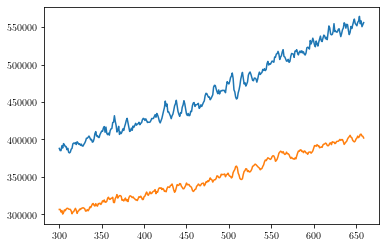

In [125]:
plt.plot(df_list[1].GDP / df_list[1].prices)
plt.plot(df_list[1].EnDem)

In [150]:
X = sm.add_constant(sm.tsa.tsatools.detrend(df_list[2].EnDem))
Y = (sm.tsa.tsatools.detrend(df_list[2].GDP / df_list[2].prices))

# print(X, Y)

mod = sm.OLS(Y, X)

res = mod.fit()

const, beta = res.params[0], res.params[1]

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     12.30
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           0.000509
Time:                        11:11:12   Log-Likelihood:                -3591.8
No. Observations:                 360   AIC:                             7188.
Df Residuals:                     358   BIC:                             7195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.223e-10    275.342  -4.44e-13      1.0

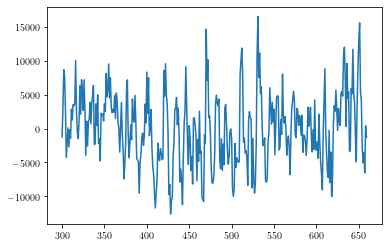

In [151]:
u = Y - beta * X.EnDem

plt.plot(u)
plt.show()

In [152]:
print(sm.tsa.stattools.adfuller(u))

(-4.627088486428048, 0.00011510674264350059, 9, 350, {'1%': -3.4491725955218655, '5%': -2.8698334971428574, '10%': -2.5711883591836733}, 6634.269852434721)


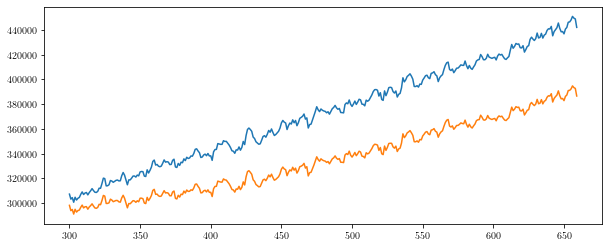

In [200]:
plt.figure(figsize=(10,4))
plt.plot(df_list[2].total_Q_cp + df_list[2].total_Q_kp)
plt.plot(df_list[2].EnDem)

In [199]:
coint_table = {}

t_stat_tot_1 = 0
n_passes_1 = 0

t_stat_tot_2 = 0
n_passes_2 = 0

t_stat_tot_3 = 0
n_passes_3 = 0

for df_i in df_list[1:3]:

    # real_gdp = df_i.GDP / df_i.prices
    real_gdp = df_i.total_Q_cp + df_i.total_Q_kp
    # real_gdp = df_i.total_Q_cp + df_i.total_Q_kp

    # endem_det = sm.tsa.tsatools.detrend(df_i.EnDem)
    # gdp_det = sm.tsa.tsatools.detrend(real_gdp)

    coint_t, pval, crit = sm.tsa.stattools.coint(df_i.EnDem, real_gdp, trend='ct')
    # res = coint_johansen(np.transpose([np.log(real_gdp), np.log(df_i.EnDem)]), det_order=1, k_ar_diff=9)
    # print(res.lr1, res.cvm)
    # coint_table['Output-EnDem'] = [round(coint_t, 2), round(pval, 2)]

    print(coint_t, pval, crit)

    t_stat_tot_1 += coint_t
    if pval <= 0.05:
        n_passes_1 += 1

    # print(coint_t, pval, crit)

    coint_t, pval, crit = sm.tsa.stattools.coint(df_i.EnDem, real_gdp, trend='ct')
    coint_table['Em-Output'] = [round(coint_t, 2), round(pval, 2)]

    # print(pval)

    t_stat_tot_2 += coint_t
    if pval <= 0.05:
        n_passes_2 += 1

    # print(coint_t, pval, crit)

    coint_t, pval, crit = sm.tsa.stattools.coint(df_i.Em, df_i.EnDem, trend='ctt')
    coint_table['Em-EnDem'] = [round(coint_t, 2), round(pval, 2)]

    # print(pval)

    t_stat_tot_3 += coint_t
    if pval <= 0.05:
        n_passes_3 += 1

-1.785446291041729 0.8497825391482554 [-4.37090157 -3.80715561 -3.51609364]
-2.057960838038494 0.7468450778215454 [-4.37090157 -3.80715561 -3.51609364]


In [198]:
print(t_stat_tot_1 / len(df_list), t_stat_tot_2 / len(df_list), t_stat_tot_3 / len(df_list))
print(n_passes_1 / len(df_list), n_passes_2 / len(df_list), n_passes_3 / len(df_list))

-2.075021629738343 -2.075021629738343 -3.39212034592565
0.03 0.03 0.22


* SF13 wealth is more concentrated at the top than at the bottom

In [64]:
all_gini_W = np.array([df.GINI_W.to_numpy() for df in df_list])
all_gini_I = np.array([df.GINI_I.to_numpy() for df in df_list])

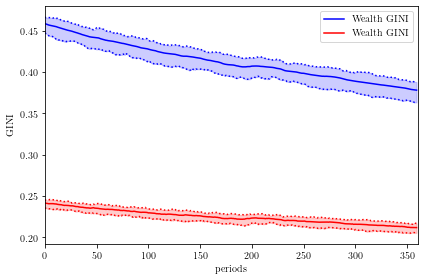

In [65]:
# res = stats.bootstrap((all_gini_W,), np.mean, method='percentile')

perc75 = np.percentile(all_gini_W, [12.5, 81.5], axis=0)
plt.plot(np.mean(all_gini_W, axis=0), color='blue', label='Wealth GINI')
plt.plot(perc75[0], color='blue', linestyle='dotted')
plt.plot(perc75[1], color='blue', linestyle='dotted')
plt.fill_between(np.arange(360), perc75[0], perc75[1], alpha=0.2, color='blue')


perc75 = np.percentile(all_gini_I, [12.5, 81.5], axis=0)
plt.plot(np.mean(all_gini_I, axis=0), color='red', label='Wealth GINI')
plt.plot(perc75[0], color='red', linestyle='dotted')
plt.plot(perc75[1], color='red', linestyle='dotted')
plt.fill_between(np.arange(360), perc75[0], perc75[1], alpha=0.2, color='red')

plt.legend(loc='upper right')
plt.xlim(0, 360)
plt.xlabel('periods')
plt.ylabel('GINI')

plt.tight_layout()
plt.savefig('../../plotting/validation/wealth_income_gini.pdf')
plt.show()

* SF2 The distribution of GDP growth rates is fat-tailed.

(Partial) reproduction of Dosi (2017) fig 2

KurtosistestResult(statistic=13.038252360117374, pvalue=7.41369565247801e-39)


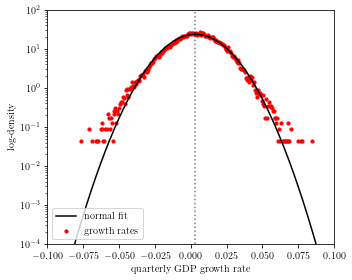

In [66]:
plt.figure(figsize=(5, 4))

data = df.GDP_growth / 100
mean_GDP_growth = np.mean(data)
x = np.linspace(-0.1, 0.1, 1000)
dens, bins, _ = plt.hist(data, bins=250, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]



bins = np.mean([bins1, bins2], axis=0)
plt.plot(x, best_fit_line, color='black', label='normal fit')
plt.scatter(bins, dens, s=10, c='red', label='growth rates')
plt.legend(loc='lower left')
plt.xlabel('quarterly GDP growth rate')
plt.ylabel('log-density')
plt.xlim(-0.1, 0.1)
plt.ylim(10e-5, 100)
plt.axvline(mean_GDP_growth, linestyle='dotted', alpha=0.5, c='black')

plt.yscale('log')
plt.tight_layout()
plt.savefig('../../plotting/validation/gr_dist.pdf', bbox_inches='tight')
plt.show()

In [73]:
z_gdp_sk_gr, p_gdp_sk_gr = stats.skewtest(data)
z_gdp_kt_gr, p_gdp_kt_gr = stats.kurtosistest(data)

print(z_gdp_kt_gr, z_gdp_sk_gr, p_gdp_kt_gr, p_gdp_sk_gr)

13.038252360117374 -8.24915454742472 7.41369565247801e-39 1.5951902938132055e-16


In [67]:
# U_filtered = sm.tsa.filters.bkfilter(np.log(df.U), bk_low, bk_high, bk_K)
# LIS_filtered = sm.tsa.filters.bkfilter(df.LIS, bk_low, bk_high, bk_K)
# C_filtered = sm.tsa.filters.bkfilter(np.log(df.C / df.prices), bk_low, bk_high, bk_K)
# I_filtered = sm.tsa.filters.bkfilter(np.log(df.I / df.prices), bk_low, bk_high, bk_K)
# Em_filtered = sm.tsa.filters.bkfilter(np.log(df.Em), bk_low, bk_high, bk_K)
# EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df.EnDem), bk_low, bk_high, bk_K)
# TotDebt_filtered = sm.tsa.filters.bkfilter(np.log(df.TotDebt / df.prices), bk_low, bk_high, bk_K)
# prices_filtered = sm.tsa.filters.bkfilter(np.log(df.prices), bk_low, bk_high, bk_K)

* SF3 The duration of recessions is exponentially distributed.

(Partial) reproduction of Dosi (2017) fig 3

In [47]:
# Count recession periods
durations = []

for df_i in df_list:

    recession = False
    duration = 0

    for g in df_i.GDP_growth:

        if g < 0:
            if recession:
                duration += 1
            else:
                recession = True
                duration = 1
            
        elif g > 0 and recession:
            recession = False
            durations += [duration]

durations = np.array(durations)

In [107]:
loc, scale = stats.expon.fit(durations)

In [108]:
counts = {}
for d in durations:
    if d not in counts:
        counts[d] = 1
    else:
        counts[d] += 1

totcount = sum(counts.values())

for c in counts:
    counts[c] /= totcount

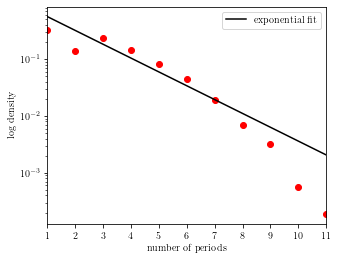

In [130]:
plt.figure(figsize=(5,4))

# dens, bins, _, plt.hist(durations, bins=11, density=True)

x = np.linspace(1, 11, 100)

plt.plot(x, stats.expon.pdf(x, loc, scale), label='exponential fit', c='black')
plt.scatter(counts.keys(), counts.values(), color='red')
# plt.scatter(np.linspace(1, max(bins), len(dens)), dens, label='simulated data', c='red', s=30, zorder=2)
plt.xlim(1, 11)
plt.xticks(range(1, 12))
plt.yscale('log')
plt.xlabel('number of periods')
plt.ylabel('log density')
plt.legend()

plt.savefig('../../plotting/validation/rec_fit.pdf', bbox_inches='tight')
plt.show()

In [94]:
print(stats.kstest(durations[np.where(durations > 2)], 'expon'))

KstestResult(statistic=0.950212931632136, pvalue=0.0)


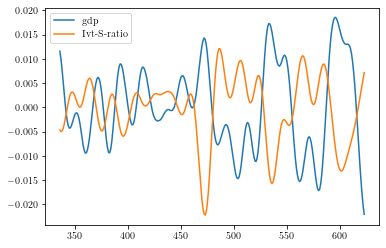

In [144]:
real_wages_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].wages / df_list[0].prices), bk_low, bk_high, bk_K)
noml_wages_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].wages), bk_low, bk_high, bk_K)
real_gdp_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].GDP / df_list[0].prices), bk_low, bk_high, bk_K)
prices_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].prices), bk_low, bk_high, bk_K)
U_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].U), bk_low, bk_high, bk_K)
Inv_S_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].inventories / (df_list[0].C / df_list[0].prices)), bk_low, bk_high, bk_K)

# plt.plot(real_wages_filtered, label='real wages')
# plt.plot(noml_wages_filtered, label='wages')
plt.plot(real_gdp_filtered, label='gdp')
plt.plot(Inv_S_filtered / 50, label='Ivt-S-ratio')
# plt.plot(U_filtered / 50, label='U')
# plt.plot(prices_filtered)
plt.legend()

In [359]:
real_wage_changes = (df_list[1].wages / df_list[1].prices).pct_change()[1:]
noml_wage_changes = df_list[1].wages.pct_change()[1:]
markup_changes = df_list[1].markups.pct_change()[1:]
price_changes = df_list[1].prices.pct_change()[1:]

# plt.scatter(real_wage_changes, markup_changes)
# plt.show()

# plt.scatter(noml_wage_changes, price_changes)
# plt.show()

# plt.scatter(markup_changes, price_changes)
# plt.show()

res = sm.OLS(price_changes, sm.add_constant(np.transpose([markup_changes, noml_wage_changes]))).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                 prices   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.689
Date:                Wed, 10 Aug 2022   Prob (F-statistic):             0.0260
Time:                        20:56:07   Log-Likelihood:                 1368.1
No. Observations:                 359   AIC:                            -2730.
Df Residuals:                     356   BIC:                            -2719.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000     -4.827      0.0

* SF5 Cross-correlations of macro-variables
    * Consumption, net investments, changes in inventories, productivity R&D investments, energy demand and nominal wages are pro-cyclical.
    * Unemployment and markups are counter-cyclical.
    * Real wages are a-cyclical.

* SF6 Synchronization of the business cycle and emission dynamics.

(Partial) replication of figure 4 in Lamperti et al (2018)

In [4]:
def compute_correlations(indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP'):

    all_corr = []

    for df_part in df_list:

        # Apply filter
        if make_real_y:
            real_GDP =  df_part[y].to_numpy() / df_part.prices.to_numpy()
        else:
            real_GDP =  df_part[y].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)

        # Prepare data
        ind_data = df_part[indicator].to_numpy()

        if indicator == 'inventories':
            ind_data = ind_data / (df_part['C'].to_numpy() / df_part['prices'].to_numpy())
        
        if make_real:
            ind_data = ind_data / df_part.prices.to_numpy()

        if apply_bk:
            ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)

        ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
        ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
        ccf = np.concatenate((ccf_back, ccf_forw))

        all_corr.append([ccf])

    avg_corr = np.transpose(np.mean(np.array(all_corr), axis=0))

    return avg_corr

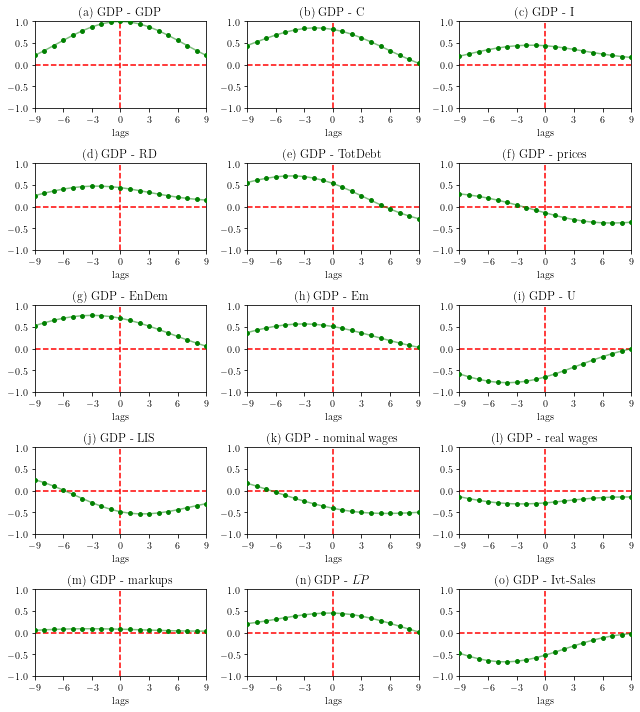

In [31]:
lags = 9
min_lag = -lags
max_lag = lags

indicators = ['GDP', 'C', 'I', 'RD', 'TotDebt', 'prices', 'EnDem', 'Em', 
              'U', 'LIS', 'wages', 'real wages', 'markups', 'avg_π_LP', 'inventories']
# indicators = ['GDP', 'C', 'I', 'U', 'EnDem', 'Em']
lags = np.arange(min_lag, max_lag + 1)

fig, axes = plt.subplots(5, 3, figsize=(9, 10))

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

    fig_nr = chr(i + 97)

    title = indicator

    apply_bk = True
    make_real = True
    if indicator in ['markups', 'U', 'EnDem', 'Em', 'LIS', 'wages', 'prices', 'avg_π_LP', 'inventories']:
        make_real=False
        if indicator == 'wages':
            title = 'nominal wages'
        elif indicator == 'avg_π_LP':
            title = '$\\bar{LP}$'
        elif indicator == 'inventories':
            title = 'Ivt-Sales'

    if indicator == 'real wages':
        indicator = 'wages'

    all_r = compute_correlations(indicator, apply_bk=apply_bk, make_real=make_real,
                                        min_lag=min_lag, max_lag=max_lag)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='red')
    ax.vlines(0, -1., 1, linestyle='dashed', color='red')

    ax.scatter(lags, all_r, color='green', zorder=10, s=15)
    ax.plot(lags, all_r, alpha=0.5, color='green', zorder=9)

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) GDP - {title}')
    ax.set_xlabel('lags')

plt.tight_layout()
# plt.savefig('../../plotting/validation/cross_correlations_short.pdf', bbox_inches='tight')
plt.show()

In [10]:
# Open all validation files

def filepath(i):
    return f'../experiments/OFAT_experiments/prog_-1.0_1_{i}.csv'

n_MC = 30

df_list = []
for MC_i in range(1, n_MC + 1):
    df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])

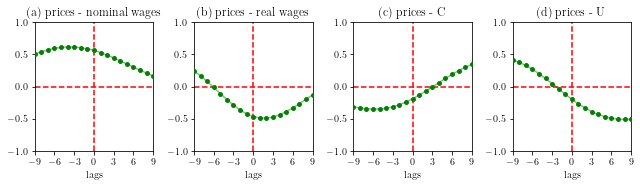

In [32]:
lags = 9
min_lag = -lags
max_lag = lags

indicators = ['wages', 'real wages', 'C', 'U']
lags = np.arange(min_lag, max_lag + 1)

fig, axes = plt.subplots(1, len(indicators), figsize=(9, 2.7))

y = 'prices'

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

    fig_nr = chr(i + 97)

    title = indicator

    apply_bk = True
    make_real = True
    if indicator in ['markups', 'U', 'EnDem', 'Em', 'LIS', 'wages', 'prices']:
        make_real=False
        if indicator == 'wages':
            title = 'nominal wages'

    if indicator == 'real wages':
        indicator = 'wages'

    all_r = compute_correlations(indicator, apply_bk=apply_bk, make_real=make_real, make_real_y=False,
                                        min_lag=min_lag, max_lag=max_lag, y=y)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='red')
    ax.vlines(0, -1., 1, linestyle='dashed', color='red')

    ax.scatter(lags, all_r, color='green', zorder=10, s=15)
    ax.plot(lags, all_r, alpha=0.5, color='green', zorder=9)

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) {y} - {title}')
    ax.set_xlabel('lags')

plt.tight_layout()
# plt.savefig('../../plotting/validation/cross_correlations_U.pdf', bbox_inches='tight')
plt.show()

In [32]:
filtered_series ={
    'GDP': sm.tsa.filters.bkfilter(np.log(df.GDP / df.prices), bk_low, bk_high, bk_K),
    '$\\hat{\\mu}$': sm.tsa.filters.bkfilter(df.markups, bk_low, bk_high, bk_K),
    'I': I_filtered.to_numpy(),
    'C': C_filtered.to_numpy(),
    'U': U_filtered.to_numpy(),
    'LIS': LIS_filtered.to_numpy(),
    'TotDebt': TotDebt_filtered.to_numpy(),
    'EnDem': EnDem_filtered.to_numpy(),
    'Em': Em_filtered.to_numpy()
}

df_filtered = pd.DataFrame(filtered_series)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

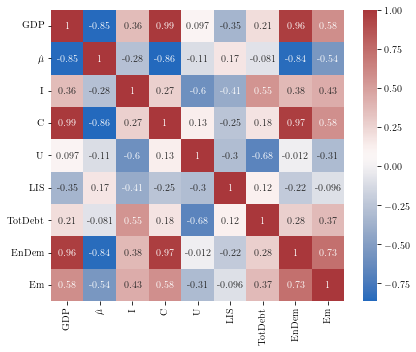

In [ ]:
import seaborn as sb
# corr = df.corr()

plt.figure(figsize=(6,5))

sb.heatmap(df_filtered.corr(), cmap="vlag", annot=True)

plt.tight_layout()
plt.show()

## Aggregate firm statistics

In [220]:
# Open all firm validation files

def filepath(i):
    return f'validation_samples/valfirmdata_{i}.csv'

n_MC = 100

df_list = []
for MC_i in range(1, n_MC + 1):
    df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])
# df = pd.concat(df_list)

In [86]:
all_firm_gr = []
all_firm_S_norm = []

for df_firm in df_list:

    S_cp_cols = [col for col in df_firms if col.startswith('Scp')]
    S_cp_month = df_firms[S_cp_cols].to_numpy()[300:,:]

    # print(S_cp_month.shape)

    # Pool data to be yearly
    S_cp_year = np.array([np.sum(S_cp_month[i:i+3, :], axis=0) for i in np.arange(0, 360, step=3)])

    S_cp_year_mean = np.mean(S_cp_year, axis=1)

    S_cp_year_norm = np.transpose(np.transpose(S_cp_year) / S_cp_year_mean)

    gr_firm = (S_cp_year_norm[:, 1:] - S_cp_year_norm[:, :-1]) / S_cp_year_norm[:, :-1]

    all_firm_gr.append(gr_firm)
    all_firm_S_norm.append(S_cp_year_norm)

    # plt.hist(firm_gr.flatten(), bins=100)
    # plt.show()
    # print(S_cp_year.shape)


    # S_cp_year_mean = np.mean(S_cp_year, axis=1)

    # print(S_cp_year_mean)

    # S_cp_year_norm = np.transpose(np.transpose(S_cp_year) / S_cp_year_mean)
    # S_cp_year_norm = np.sort(S_cp_year_norm.flatten())[::-1]

In [49]:
np.array(all_firm_gr).flatten().shape

(2388000,)

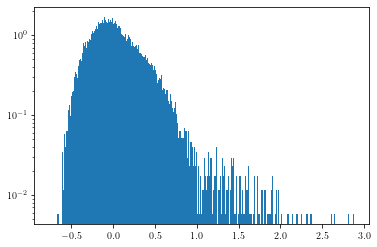

In [52]:
plt.hist(np.array(all_firm_gr).flatten(), bins=500, density=True)
plt.yscale('log')
plt.show()

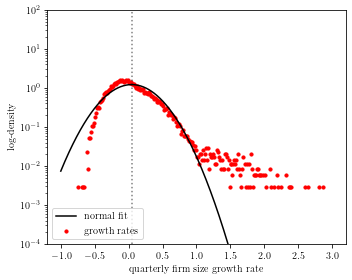

In [82]:
plt.figure(figsize=(5, 4))

data = np.array(all_firm_gr).flatten()
mean_firm_growth = np.mean(data)
x = np.linspace(-1., 3., 1000)
dens, bins, _ = plt.hist(data, bins=250, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]

bins = np.mean([bins1, bins2], axis=0)
plt.plot(x, best_fit_line, color='black', label='normal fit')
plt.scatter(bins, dens, s=10, c='red', label='growth rates')
plt.legend(loc='lower left')
plt.xlabel('quarterly firm size growth rate')
plt.ylabel('log-density')
# plt.xlim(-0.1, 0.1)
plt.ylim(10e-5, 100)
plt.axvline(mean_firm_growth, linestyle='dotted', alpha=0.5, c='black')

plt.yscale('log')
plt.tight_layout()
plt.savefig('../../plotting/validation/gr_firm_dist.pdf', bbox_inches='tight')
plt.show()

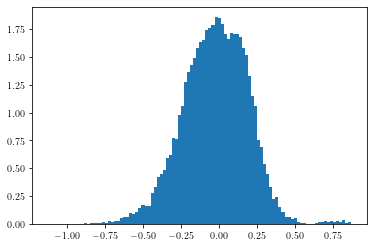

In [92]:
plt.hist(np.log(np.array(all_firm_S_norm).flatten()), bins=100, density=True)
plt.show()

In [97]:
z_frm_sk_sz, p_frm_sk_sz =  stats.skewtest(np.array(all_firm_S_norm).flatten())
z_frm_kt_sz, p_frm_kt_sz = stats.kurtosistest(np.array(all_firm_S_norm).flatten())

print(z_frm_sk_sz, p_frm_sk_sz, z_frm_kt_sz, p_frm_kt_sz)

468.66375511814323 0.0 420.9671192350816 0.0


In [83]:
z_frm_sk_gr, p_frm_sk_gr =  stats.skewtest(data)
z_frm_kt_gr, p_frm_kt_gr = stats.kurtosistest(data)

In [98]:
z_gdp_kt_gr, z_gdp_sk_gr, p_gdp_kt_gr, p_gdp_sk_gr

gr_dict = {
    'output growth': [z_gdp_sk_gr, p_gdp_sk_gr, z_gdp_kt_gr, p_gdp_kt_gr],
    'firm growth': [z_frm_sk_gr, p_frm_sk_gr, z_frm_kt_gr, p_frm_kt_gr],
    'firm size': [z_frm_sk_sz, p_frm_sk_sz, z_frm_kt_sz, p_frm_kt_sz]
}

In [103]:
rownames = [
    'skew test stat',
    'skew p val',
    'kurt test stat',
    'kurt p val'
]

In [106]:
df_gr = pd.DataFrame(gr_dict, index=rownames).round(3)

df_gr.head()

print(df_gr.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  output growth &  firm growth &  firm size \\
\midrule
skew test stat &         -8.249 &      702.873 &    468.664 \\
skew p val     &          0.000 &        0.000 &      0.000 \\
kurt test stat &         13.038 &      514.802 &    420.967 \\
kurt p val     &          0.000 &        0.000 &      0.000 \\
\bottomrule
\end{tabular}



In [294]:
def plot_avg_pi(ts, ax, label, color):
    ts_reshape = np.array(ts).reshape(ts.shape[0] * ts.shape[1], 360)
    perc75 = np.percentile(ts_reshape, [12.5, 81.5], axis=0)

    ax.plot(perc75[0], color=color, linestyle='dotted', alpha=0.5)
    ax.plot(perc75[1], color=color, linestyle='dotted', alpha=0.5)
    ax.fill_between(range(360), perc75[0], perc75[1], color=color, alpha=0.2)
    ax.plot(np.mean(ts_reshape, axis=0), color=color, label=label)
    ax.set_xlim(0, 360)
    ax.set_xlabel('periods')
    ax.set_ylabel('tech level')
    ax.legend()

    return ax

In [295]:
def add_data_pi(df, indicator):
    LP_cols = [col for col in df_i if col.startswith(indicator)]
    all_ts = df_i[LP_cols]
    # all_LP_cp.append(np.transpose(df_i[LP_cols]))
    return np.transpose(df_i[LP_cols])

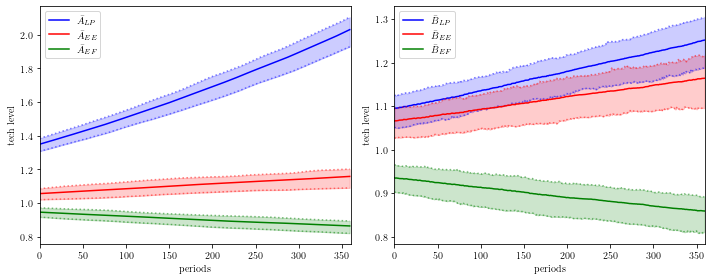

In [297]:
all_LP_cp = []
all_LP_kp = []

all_EE_cp = []
all_EE_kp = []

all_EF_cp = []
all_EF_kp = []

for df_i in df_list:
    all_LP_cp.append(add_data_pi(df_i, 'LPcp'))
    all_EE_cp.append(add_data_pi(df_i, 'EEcp'))
    all_EF_cp.append(add_data_pi(df_i, 'EFcp'))

    all_LP_kp.append(add_data_pi(df_i, 'LPkp'))
    all_EE_kp.append(add_data_pi(df_i, 'EEkp'))
    all_EF_kp.append(add_data_pi(df_i, 'EFkp'))

all_LP_cp = np.array(all_LP_cp)
all_LP_kp = np.array(all_LP_kp)

all_EE_cp = np.array(all_EE_cp)
all_EE_kp = np.array(all_EE_kp)

all_EF_cp = np.array(all_EF_cp)
all_EF_kp = np.array(all_EF_kp)

# all_LP_cp = np.array(all_LP_cp).reshape(20000, 360)
# perc75_LP_cp = np.percentile(all_LP_cp, [12.5, 81.5], axis=0)

# all_LP_kp = np.array(all_LP_kp).reshape(20000, 360)
# perc75_LP_kp = np.percentile(all_LP_kp, [12.5, 81.5], axis=0)

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))

plot_avg_pi(all_LP_cp, ax1, '$\\bar{A}_{LP}$', 'blue')
plot_avg_pi(all_EE_cp, ax1, '$\\bar{A}_{EE}$', 'red')
plot_avg_pi(all_EF_cp, ax1, '$\\bar{A}_{EF}$', 'green')

plot_avg_pi(all_LP_kp, ax2, '$\\bar{B}_{LP}$', 'blue')
plot_avg_pi(all_EE_kp, ax2, '$\\bar{B}_{EE}$', 'red')
plot_avg_pi(all_EF_kp, ax2, '$\\bar{B}_{EF}$', 'green')

# ax1.plot(perc75_LP_cp[0], color='blue', linestyle='dotted', alpha=0.5)
# ax1.plot(perc75_LP_cp[1], color='blue', linestyle='dotted', alpha=0.5)
# ax1.fill_between(range(360), perc75_LP_cp[0], perc75_LP_cp[1], color='blue', alpha=0.2)
# ax1.plot(np.mean(all_LP_cp, axis=0), color='blue', label='$\\bar{A}_{LP}$')
# ax1.set_xlim(0, 360)
# ax1.legend()

plt.tight_layout()
plt.savefig('../../plotting/validation/tech_het.pdf')
plt.show()

In [ ]:
all_LP_std = []
all_EF_std = []
all_EE_std = []

for df_i in df_list:
    LP_cols = [col for col in df_i if col.startswith('LPcp')]
    all_ts = df_i[LP_cols]
    all_LP_std.append(np.std(df_i[LP_cols], axis=1))

    EF_cols = [col for col in df_i if col.startswith('EFcp')]
    all_ts = df_i[EF_cols]
    all_EF_std.append(np.std(df_i[EF_cols], axis=1))

    EE_cols = [col for col in df_i if col.startswith('EEcp')]
    all_ts = df_i[EE_cols]
    all_EE_std.append(np.std(df_i[EE_cols], axis=1))

LP_bootstrap = stats.bootstrap((np.array(all_LP_std),), np.mean, method='percentile', n_resamples=100)
EF_bootstrap = stats.bootstrap((np.array(all_EF_std),), np.mean, method='percentile', n_resamples=100)
EE_bootstrap = stats.bootstrap((np.array(all_EE_std),), np.mean, method='percentile', n_resamples=100)

lower_LP = LP_bootstrap.confidence_interval.low
upper_LP = LP_bootstrap.confidence_interval.high

lower_EF = EF_bootstrap.confidence_interval.low
upper_EF = EF_bootstrap.confidence_interval.high

lower_EE = EE_bootstrap.confidence_interval.low
upper_EE = EE_bootstrap.confidence_interval.high

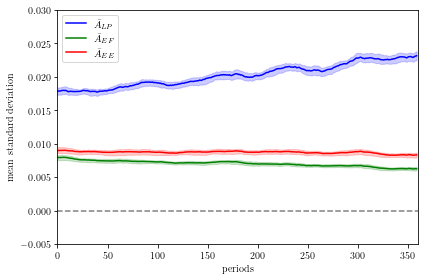

In [256]:
plt.plot(np.mean(all_LP_std, axis=0), color='blue', label='$\\bar{A}_{LP}$')
plt.fill_between(range(len(all_LP_std[0])), lower_LP, upper_LP, color='blue', alpha=0.2)

plt.plot(np.mean(all_EF_std, axis=0), color='green', label='$\\bar{A}_{EF}$')
plt.fill_between(range(len(all_EF_std[0])), lower_EF, upper_EF, color='green', alpha=0.2)

plt.plot(np.mean(all_EE_std, axis=0), color='red', label='$\\bar{A}_{EE}$')
plt.fill_between(range(len(all_EE_std[0])), lower_EE, upper_EE, color='red', alpha=0.2)

plt.axhline(0.0, linestyle='dashed', c='black', alpha=0.5)
plt.xlim(0, 360)
plt.ylim(-0.005, 0.03)
plt.ylabel('mean standard deviation')
plt.xlabel('periods')

plt.legend()
plt.tight_layout()
plt.show()

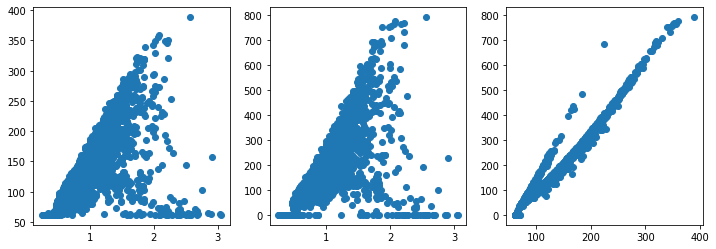

In [10]:
df_hh_income = pd.read_csv('../result_data/final_income_dists.csv')
df_hh_income.head()

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(df_hh_income.skills, df_hh_income.all_I)

ax2.scatter(df_hh_income.skills, df_hh_income.all_W)

ax3.scatter(df_hh_income.all_I, df_hh_income.all_W)

plt.show()